In [1]:
from __future__ import division
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from timeit import default_timer
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import random
import argparse
from tqdm import tqdm
import librosa
from torchvision.models import densenet121
from torchvision.models import mobilenet_v2
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
!nvidia-smi

Fri Aug  2 12:23:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:08:00.0  On |                  N/A |
| 63%   53C    P2             119W / 250W |   1550MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
EPOCHS = 20
SEED = 2024
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.25
N_FFT = 256
HOP_LEN = 256 // 6
AUGM = True # Augmentation
# Creating the results directory
if not os.path.exists('results'):
    os.makedirs('results')
RESULTS_FILENAME = "./results/inrun_results" # _x.csv
VALID_RESULTS_FILENAME = "./results/valid_results" # _x.csv
TRAIN_RESULTS_FILENAME = "./results/train_results" # _x.csv
BEST_MODEL_FILENAME = "./results/best-model" # _x.pt
EVAL_FREQ=4
NUM_SIMS = 5

In [4]:
TRAIN_DATASET = "../data/train_whales.csv"
TEST_DATASET = "../data/test_whales.csv"

In [5]:
# Fixing the seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Cuda is available: {torch.cuda.is_available()}")
dev_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(f"Device: {dev_names}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is available: True
Device: ['NVIDIA GeForce RTX 3090']


In [6]:
target_names = ["no-whale","whale"]
target_names_dict = {target_names[i]: i for i in range(len(target_names))}

# Loading the data

In [7]:
t_s = default_timer()
data_train = pd.read_csv(TRAIN_DATASET,sep=",")
columns = data_train.columns
data_train[columns[-1]]=data_train[columns[-1]].replace(target_names_dict)
data_train = data_train.values
data_train_labels = data_train[:,-1].reshape(-1)
data_train_labels = data_train_labels.astype(int)
data_train = data_train[:,:-1]

data_test = pd.read_csv(TEST_DATASET,sep=",")
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]
t_e = default_timer()

print(f"Data loading - Elapsed time: {t_e-t_s:.2f}s")

Data loading - Elapsed time: 8.77s


In [8]:
data_train.shape, data_test.shape

((10316, 4000), (2580, 4000))

In [9]:
print(data_train.shape)

X_train, X_valid, y_train, y_valid = train_test_split(data_train, data_train_labels, stratify = data_train_labels, test_size = TEST_SPLIT_RATIO, random_state = SEED)   
X_test, y_test = data_test, data_test_labels


(10316, 4000)


In [10]:
len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), len(y_test)

(7737, 2579, 2580, 7737, 2579, 2580)

In [11]:
# balance
y_train.sum(), len(y_train) - y_train.sum()

(3869, 3868)

In [12]:
y_valid.sum(), len(y_valid) - y_valid.sum()

(1289, 1290)

In [13]:
y_test.sum(), len(y_test) - y_test.sum()

(1290, 1290)

In [14]:
def random_data_shift(data, u=1.0):
    if np.random.random() < u:
        shift = int(round(np.random.uniform(-len(data)*0.25, len(data)*0.25)))
        data = np.roll(data, shift)
    return data

In [15]:
test = np.arange(20)
print(test.shape, test)
test_out = random_data_shift(test)
print(test_out.shape,test_out)

(20,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(20,) [18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [16]:
class AugmentedSTFTDataset(Dataset):
    def __init__(self, inputs, targets, n_fft, hop_length, augment=False):
        self.inputs = inputs
        self.targets = targets
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        sample = self.inputs[idx]
        
        if self.augment:
            sample = random_data_shift(sample)
            
        data = librosa.stft(sample, n_fft=self.n_fft, hop_length=self.hop_length)
        data = librosa.amplitude_to_db(np.abs(data), ref=np.max)
        data = np.flipud(data)  # Flip vertically
        data = data.copy()  
        data = np.expand_dims(data, axis=-1)  # Add channel dimension
        data = np.transpose(data, (2, 0, 1))  # Reorder dimensions to match PyTorch expectations
        return torch.FloatTensor(data), torch.LongTensor([self.targets[idx]])

# Data loader
def create_dataloader(inputs, targets, batch_size, n_fft, hop_length, shuffle=True, augment=False):
    dataset = AugmentedSTFTDataset(inputs, targets, n_fft, hop_length, augment=augment)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [17]:
train_loader = create_dataloader(X_train, y_train, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=True, augment=AUGM)
valid_loader = create_dataloader(X_valid, y_valid, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=False, augment=False) 
test_loader = create_dataloader(X_test, y_test, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=False, augment=False) 


In [18]:
EVAL_FREQ = len(train_loader)//EVAL_FREQ

In [19]:
print(len(train_loader), EVAL_FREQ)

242 60


In [20]:
for x, y in train_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 1, 129, 96]) torch.Size([32, 1])


In [21]:
for x, y in valid_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 1, 129, 96]) torch.Size([32, 1])


# Model

In [22]:
class MobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = mobilenet_v2(weights=None).features
        self.model[0][0] = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.classifier = torch.nn.Sequential(torch.nn.Linear(1280, 1))
        
    def forward(self, x):
        out = self.model.forward(x)
        out = torch.nn.functional.avg_pool2d(out, kernel_size = out.shape[2:], stride= out.shape[2:], padding=0, count_include_pad = False)
        out = self.classifier(out.view(out.shape[0], -1))
        return out

In [23]:
model = MobileNetV2()
#model.to(device)

# Utilities

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    number_of_elements = 0
    
    correct_pred = torch.zeros(2)
    total_pred = torch.zeros(2)


    with torch.no_grad():
        
        y_true = []
        y_pred = []
        for x, y in iterator:

            x = x.to(device)
            y = y.float().to(device).view(-1,1)
            
            batch_size = x.shape[0]
            number_of_elements += batch_size
            
            pred = model(x).view(-1,1)
            loss = criterion(pred, y)
            
            top_pred = (torch.sigmoid(pred) > 0.5).int()
            acc = top_pred.eq(y.int().view_as(top_pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            y_true.append(y.int().cpu().numpy())
            y_pred.append(top_pred.cpu().numpy())
            
        y_true_a = np.concatenate(y_true, axis=0)
        y_pred_a = np.concatenate(y_pred, axis=0)
                        
        #balanced_acc = balanced_accuracy_score(y_true_a, y_pred_a)
        acc = accuracy_score(y_true_a, y_pred_a)

    return epoch_loss / number_of_elements, acc

# Evaluation

## Accuracies and losses



In [26]:
epoch_df = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{0}.csv",sep=";")
epoch_df = epoch_df.drop_duplicates(subset=['epoch'], keep='first')
epoch_df = epoch_df.drop(["valid_loss","valid_acc"], axis=1)
epoch_df["epoch"] = epoch_df["epoch"].astype(str)
df_new = epoch_df.set_index("epoch")
for i in range(5):
    df_valid = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_valid = df_valid.rename(columns={"valid_loss":f"valid_loss_{i}","valid_acc":f"valid_acc_{i}"})
    df_valid["epoch"] = df_valid["epoch"].astype(str)
    df_valid = df_valid.drop_duplicates(subset=['epoch'], keep='first')
    df_valid = df_valid.set_index("epoch")
    df_new = df_new.join(df_valid)


In [27]:
df_new = df_new.reset_index()
df_new["epoch"] = df_new["epoch"].astype(float)

df_new["valid_loss_max"]=df_new[[f"valid_loss_{i}" for i in range(5)]].max(axis=1)
df_new["valid_loss_min"]=df_new[[f"valid_loss_{i}" for i in range(5)]].min(axis=1)
df_new["valid_loss_mean"]=df_new[[f"valid_loss_{i}" for i in range(5)]].mean(axis=1)

df_new["valid_acc_max"]=df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=1)
df_new["valid_acc_min"]=df_new[[f"valid_acc_{i}" for i in range(5)]].min(axis=1)
df_new["valid_acc_mean"]=df_new[[f"valid_acc_{i}" for i in range(5)]].mean(axis=1)

In [28]:
df_new

,epoch,valid_loss_0,valid_acc_0,valid_loss_1,valid_acc_1,valid_loss_2,valid_acc_2,valid_loss_3,valid_acc_3,valid_loss_4,valid_acc_4,valid_loss_max,valid_loss_min,valid_loss_mean,valid_acc_max,valid_acc_min,valid_acc_mean
0,0.247934,0.692967,51.725475,0.693014,49.980613,0.692811,50.988755,0.696918,50.019387,0.703308,49.980613,0.703308,0.692811,0.695803,51.725475,49.980613,50.538969
1,0.495868,0.692910,50.290810,0.692552,50.019387,0.692757,50.019387,0.693060,50.368360,0.692777,50.019387,0.693060,0.692552,0.692811,50.368360,50.019387,50.143466
2,0.743802,0.693986,49.980613,0.692943,50.019387,0.692422,54.168282,0.693163,49.980613,0.693811,50.019387,0.693986,0.692422,0.693265,54.168282,49.980613,50.833656
3,0.991736,0.693151,49.980613,0.693467,49.980613,0.692251,49.980613,0.694167,50.019387,0.691907,50.019387,0.694167,0.691907,0.692989,50.019387,49.980613,49.996123
4,1.000000,0.692948,49.980613,0.693089,49.980613,0.692092,57.968205,0.694920,50.019387,0.691823,50.096937,0.694920,0.691823,0.692974,57.968205,49.980613,51.609151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19.247934,0.349217,84.257464,0.270461,88.134936,0.364900,82.939124,0.313392,85.537030,0.277102,88.057387,0.364900,0.270461,0.315015,88.134936,82.939124,85.785188
96,19.495868,0.348807,84.373788,0.268901,88.251260,0.363774,82.977898,0.311902,86.002326,0.276692,87.941062,0.363774,0.268901,0.314015,88.251260,82.977898,85.909267
97,19.743802,0.349332,84.257464,0.268319,88.212485,0.363915,82.939124,0.310685,85.924777,0.276893,87.941062,0.363915,0.268319,0.313829,88.212485,82.939124,85.854983
98,19.991736,0.348777,84.296239,0.267696,88.290035,0.364015,83.094223,0.310762,85.847228,0.276364,87.863513,0.364015,0.267696,0.313523,88.290035,83.094223,85.878247


In [29]:
EPOCHS = np.max(df_new["epoch"].values).astype(int)
epochs_train = np.arange(1,EPOCHS+1)
df_new_train = pd.DataFrame({"epoch":epochs_train})
df_new_train = df_new_train.set_index("epoch")

for i in range(5):
    df_train = pd.read_csv(f"{TRAIN_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_train = df_train.rename(columns={"train_loss":f"train_loss_{i}","train_acc":f"train_acc_{i}"})
    
    df_train = df_train.set_index("epoch")
    df_new_train = df_new_train.join(df_train)

df_new_train["train_loss_max"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_loss_min"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_loss_mean"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].mean(axis=1)

df_new_train["train_acc_max"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_acc_min"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_acc_mean"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].mean(axis=1)
df_new_train = df_new_train.reset_index()

In [30]:
df_new_train

,epoch,train_loss_0,train_acc_0,train_loss_1,train_acc_1,train_loss_2,train_acc_2,train_loss_3,train_acc_3,train_loss_4,train_acc_4,train_loss_max,train_loss_min,train_loss_mean,train_acc_max,train_acc_min,train_acc_mean
0,1,0.692992,50.006462,0.693146,50.006462,0.692239,56.624014,0.694992,49.993538,0.691846,50.096937,0.694992,0.691846,0.693043,56.624014,49.993538,51.345483
1,2,0.610586,66.718366,0.540642,73.762440,0.545170,73.193744,0.722973,54.155357,0.640952,59.545043,0.722973,0.540642,0.612064,73.762440,54.155357,65.474990
2,3,0.493973,76.360346,0.506207,77.097066,0.482935,77.614062,0.505950,75.326354,0.484008,77.510663,0.506207,0.482935,0.494615,77.614062,75.326354,76.781698
3,4,0.525291,74.137263,0.463373,78.673905,0.462144,78.260308,0.461453,78.816079,0.459986,78.402482,0.525291,0.459986,0.474449,78.816079,74.137263,77.658007
4,5,0.465269,78.402482,0.432423,79.992245,0.449989,79.242600,0.440471,79.824221,0.447530,80.289518,0.465269,0.432423,0.447136,80.289518,78.402482,79.550213
5,6,0.444686,79.514024,0.404883,81.530309,0.463375,79.048727,0.411679,81.207186,0.390878,82.279953,0.463375,0.390878,0.423100,82.279953,79.048727,80.716040
6,7,0.518343,76.967817,0.377083,83.081298,0.451749,78.609280,0.409179,81.129637,0.399317,83.973116,0.518343,0.377083,0.431134,83.973116,76.967817,80.752230
7,8,0.419499,80.754815,0.339837,85.226832,0.419189,81.077937,0.382303,83.081298,0.333515,85.213907,0.419499,0.333515,0.378868,85.226832,80.754815,83.070958
8,9,0.415228,81.026238,0.311983,86.661497,0.407424,81.452759,0.369582,84.089440,0.315546,86.299599,0.415228,0.311983,0.363953,86.661497,81.026238,83.905907
9,10,0.387653,82.254104,0.309752,86.919995,0.404539,81.866356,0.349742,84.735686,0.292844,87.307742,0.404539,0.292844,0.348906,87.307742,81.866356,84.616777


In [31]:
SMALL_SIZE = 15
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

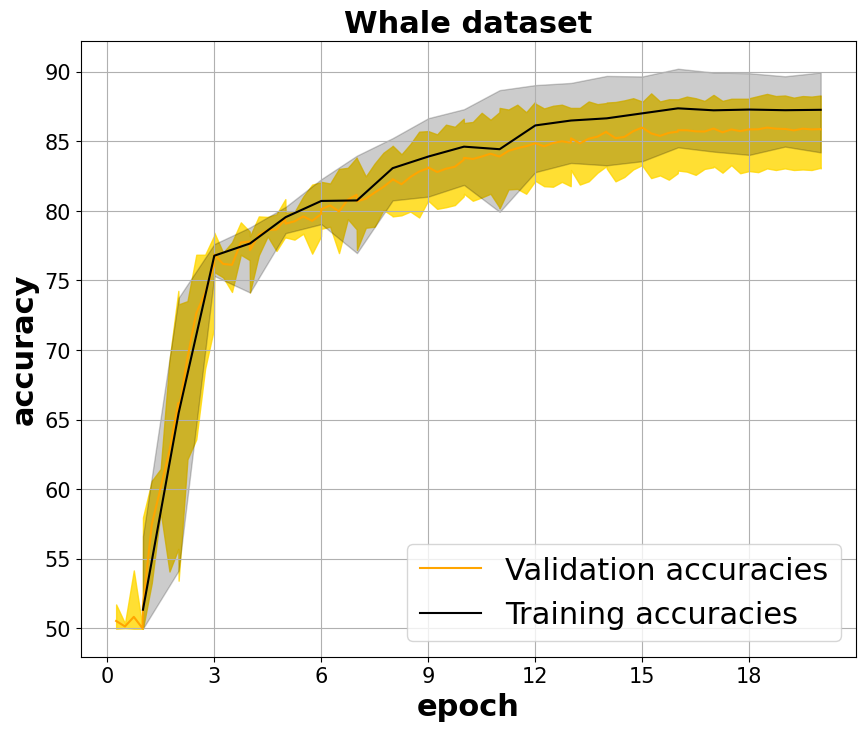

In [32]:
# Accuracies
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_acc_mean"], 'orange',label="Validation accuracies")
ax.fill_between(df_new["epoch"], df_new["valid_acc_min"],df_new["valid_acc_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_acc_mean"], 'k-',label="Training accuracies")
ax.fill_between(df_new_train["epoch"], df_new_train["train_acc_min"],df_new_train["train_acc_max"], color='k', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold")
plt.ylabel("accuracy",weight="bold")
plt.legend()
plt.grid()
plt.title(f"Whale dataset",fontsize=22,weight="bold")
plt.show(block=False)
fig.savefig('mobilenet_accuracies.svg', format='svg')


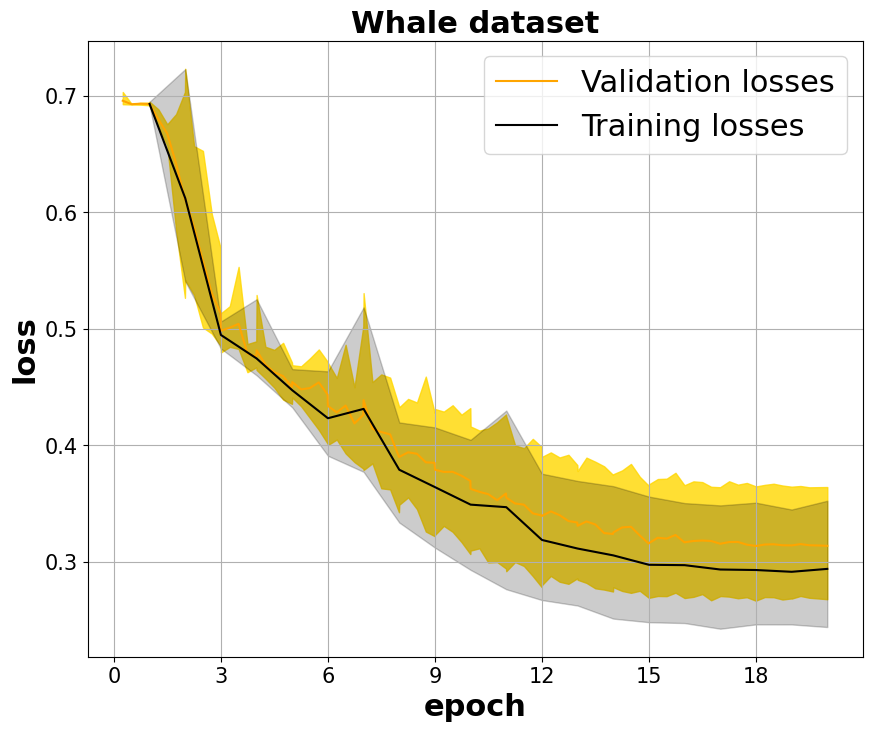

In [33]:
# Losses
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_loss_mean"], 'orange',label="Validation losses")
ax.fill_between(df_new["epoch"], df_new["valid_loss_min"],df_new["valid_loss_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_loss_mean"], 'k-',label="Training losses")
ax.fill_between(df_new_train["epoch"], df_new_train["train_loss_min"],df_new_train["train_loss_max"], color='k', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold")
plt.ylabel("loss",weight="bold")
plt.legend()
plt.grid()
plt.title(f"Whale dataset",fontsize=22,weight="bold")
plt.show(block=False)
fig.savefig('mobilenet_losses.svg', format='svg')

## The best model

In [34]:
# The model with the best validation accuracy
IND = np.argmax(df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=0).values)
IND

1

In [35]:
state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{IND}.pt")

In [36]:
model = MobileNetV2()

In [37]:
model.load_state_dict(state_dict)
model.to(device)
print(f"Number of the parameters: {count_parameters(model)}\n")
criterion = torch.nn.BCEWithLogitsLoss(reduction="sum").to(device)

train_loss, train_acc = evaluate(model, train_loader, criterion, device)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(160*"-"+"\n")
print(f"The model with the best validation accuracy:")
print(f'Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t\n')

Number of the parameters: 2224577

----------------------------------------------------------------------------------------------------------------------------------------------------------------

The model with the best validation accuracy:
Train Loss: 0.253 -  Train Acc: 89.69% | Valid Loss: 0.270 - Valid Acc: 88.45% | Test Loss: 0.267 - Test Acc: 89.19% 	



In [38]:
y_preds = []
y_true = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_true.append(y.view(-1,1))

        x = x.to(device)
        y = y.to(device)
                
        y_pred = model(x)
            
        top_pred = (torch.sigmoid(y_pred) > 0.5).int()
        y_preds.append(top_pred.detach().cpu().view(-1,1))

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)
results = classification_report(y_true, y_preds, target_names=target_names,output_dict=True)
print(pd.DataFrame(results).T,"\n")

              precision    recall  f1-score     support
no-whale       0.852756  0.947287  0.897539  1290.00000
whale          0.940715  0.836434  0.885515  1290.00000
accuracy       0.891860  0.891860  0.891860     0.89186
macro avg      0.896736  0.891860  0.891527  2580.00000
weighted avg   0.896736  0.891860  0.891527  2580.00000 



In [39]:
# Recall accuracy 
recall_score(y_true,y_preds)

0.8364341085271317

## Confusion matrix

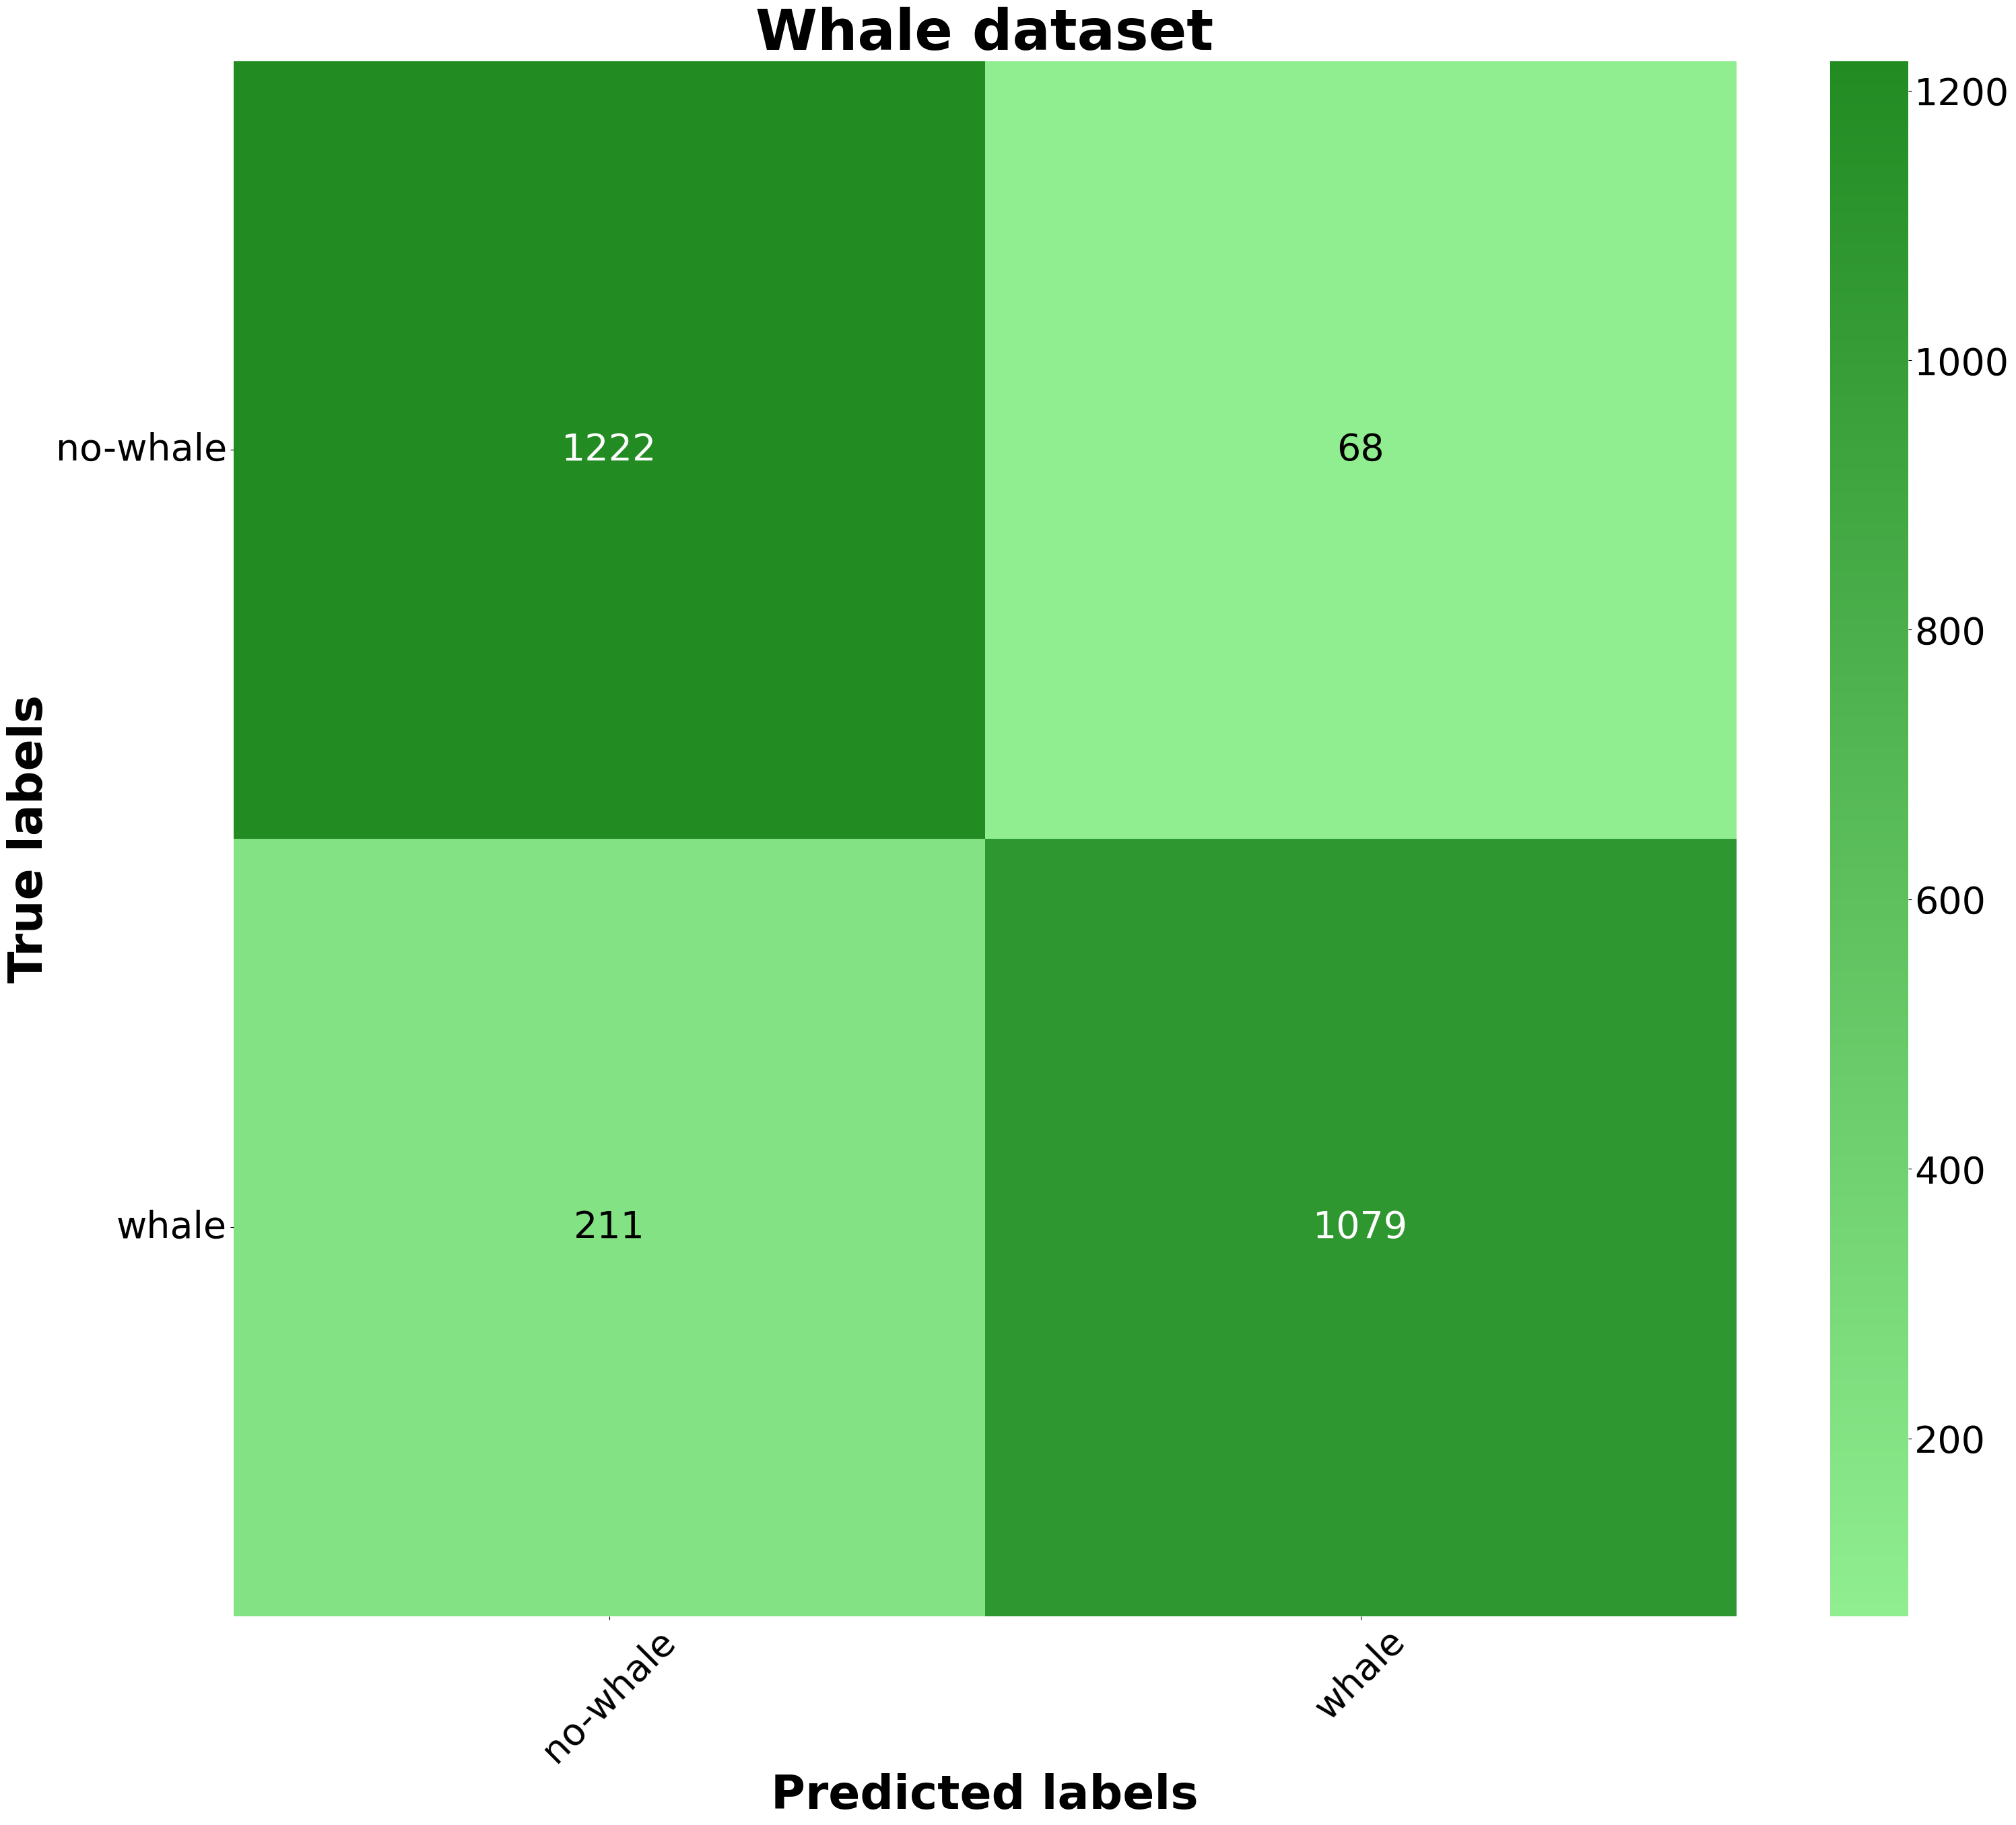

In [40]:
cm = confusion_matrix(y_true, y_preds, labels=list(range(len(target_names))))

# Adjust font sizes and styles
SMALL_SIZE = 50
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title is effectively disabled
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize is effectively disabled
plt.rc('figure', titlesize=0)  # fontsize of the figure title is effectively disabled

# Create a custom colormap from light green to forest green

light_to_forest_green_cmap = LinearSegmentedColormap.from_list("light_to_forest_green", ["lightgreen", "forestgreen"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
# Create the heatmap but without annotations
sns.heatmap(cm, cmap=light_to_forest_green_cmap, ax=ax)

# Manually add the annotations with specific color conditions
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Determine the color based on the condition
        color = 'white' if (i, j) not in [(0, 1), (1, 0)] else 'black'
        ax.text(j + 0.5, i + 0.5, cm[i, j], ha="center", va="center", color=color, fontsize=MEDIUM_SIZE)

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title("Whale dataset", fontsize=60, weight="bold")

# Display the plot
plt.show()

# Save the figure
fig.savefig('mobilenet_cm.svg', format='svg')


## Accuracies among the 5 models

In [41]:
final_results = {"train_losses":[],
                 "train_accuracies":[],
                 "valid_losses":[],
                 "valid_accuracies":[],
                 "test_losses":[],
                 "test_accuracies":[],
                 "test_recalls":[]}

In [42]:
for ind in range(5):
    model = MobileNetV2()
    state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{ind}.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    train_loss, train_acc = evaluate(model, train_loader, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    final_results["train_losses"].append(train_loss)
    final_results["train_accuracies"].append(train_acc)
    
    final_results["valid_losses"].append(valid_loss)
    final_results["valid_accuracies"].append(valid_acc)
    
    final_results["test_losses"].append(test_loss)
    final_results["test_accuracies"].append(test_acc)

    y_preds = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_true.append(y.view(-1,1))

            x = x.to(device)
            y = y.to(device)
                
            y_pred = model(x)
            
            top_pred = (torch.sigmoid(y_pred) > 0.5).int()
            y_preds.append(top_pred.detach().cpu().view(-1,1))

        y_preds = torch.cat(y_preds)
        y_true = torch.cat(y_true)
    test_recall = recall_score(y_true,y_preds)
    
    final_results["test_recalls"].append(test_recall)
    
    print(f'Model {ind} | Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t')

Model 0 | Train Loss: 0.329 -  Train Acc: 85.60% | Valid Loss: 0.348 - Valid Acc: 84.84% | Test Loss: 0.350 - Test Acc: 84.96% 	
Model 1 | Train Loss: 0.252 -  Train Acc: 89.43% | Valid Loss: 0.270 - Valid Acc: 88.45% | Test Loss: 0.267 - Test Acc: 89.19% 	
Model 2 | Train Loss: 0.353 -  Train Acc: 83.99% | Valid Loss: 0.365 - Valid Acc: 83.29% | Test Loss: 0.370 - Test Acc: 83.57% 	
Model 3 | Train Loss: 0.298 -  Train Acc: 87.26% | Valid Loss: 0.319 - Valid Acc: 86.20% | Test Loss: 0.331 - Test Acc: 86.55% 	
Model 4 | Train Loss: 0.264 -  Train Acc: 88.73% | Valid Loss: 0.280 - Valid Acc: 88.10% | Test Loss: 0.289 - Test Acc: 87.95% 	


In [43]:
print(f"Mean test accuracy: {np.mean(final_results['test_accuracies']):.4f}")
print(f"Mean test recall: {np.mean(final_results['test_recalls']):.4f}")

Mean test accuracy: 0.8644
Mean test recall: 0.8189
